Get dataset from official repository


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/karolpiczak/ESC-50.git
!ls

Cloning into 'ESC-50'...
remote: Enumerating objects: 4136, done.
remote: Total 4136 (delta 0), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4136/4136), 878.77 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Checking out files: 100% (2011/2011), done.
drive  ESC-50  sample_data


In [2]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

library for live plotting of the training accuracy and loss

In [3]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

Read wav files

In [ ]:



ROOT = '/content/ESC-50/audio'

audio_list = []
for audio in Path(ROOT).iterdir():
    try:
        sr, this_sound = wavfile.read(audio)
        audio_list.append(this_sound)
    except:
        print('cannot read ', str(audio))

print(len(audio_list))
audio = (np.array(audio_list))
print(np.shape(audio))

del audio_list

#why is not already normalized
audio = np.float32(audio)/np.max(np.abs(audio))

2000
(2000, 220500)


Read csv file

In [ ]:
colnames = ['filename','fold','target','category','esc10','src_file','take']
csv = pd.read_csv('/content/ESC-50/meta/esc50.csv', header=0)
label_list = csv.target.tolist()
fold_list = csv.fold.tolist()
category_list = csv.category.tolist()

print(label_list)
print(fold_list)

label = np.float32(np.array(label_list))

class_dict = dict(zip(label_list, category_list))

print(class_dict)

[0, 14, 36, 36, 19, 19, 30, 34, 9, 30, 30, 22, 22, 22, 0, 22, 19, 48, 48, 48, 48, 22, 22, 22, 41, 47, 31, 17, 45, 8, 15, 15, 15, 46, 46, 37, 32, 16, 37, 25, 25, 25, 25, 25, 25, 4, 4, 48, 48, 3, 15, 27, 27, 43, 12, 40, 40, 40, 40, 40, 40, 29, 10, 12, 7, 12, 12, 12, 26, 4, 6, 6, 40, 40, 44, 44, 23, 31, 20, 4, 4, 4, 49, 43, 24, 24, 7, 8, 8, 36, 36, 36, 41, 41, 41, 39, 3, 28, 18, 2, 2, 2, 2, 2, 20, 20, 20, 10, 46, 35, 38, 38, 25, 20, 20, 46, 44, 15, 15, 19, 19, 49, 35, 35, 43, 43, 19, 19, 19, 47, 43, 48, 48, 2, 2, 2, 21, 43, 43, 30, 10, 1, 35, 35, 28, 28, 1, 18, 11, 11, 43, 16, 10, 21, 26, 26, 18, 0, 0, 23, 23, 23, 24, 6, 6, 42, 42, 21, 4, 4, 0, 35, 35, 29, 26, 5, 5, 1, 1, 14, 14, 37, 38, 26, 26, 23, 23, 23, 23, 47, 29, 14, 14, 9, 9, 11, 11, 1, 28, 46, 28, 1, 28, 34, 12, 38, 1, 11, 34, 47, 47, 47, 47, 1, 27, 31, 14, 12, 18, 49, 36, 7, 7, 41, 41, 21, 21, 16, 16, 5, 5, 5, 28, 46, 38, 35, 8, 8, 10, 44, 44, 15, 17, 44, 17, 16, 16, 16, 25, 18, 17, 17, 33, 33, 33, 33, 33, 33, 33, 33, 24, 30, 24,

# PREPROCESSING

In [ ]:

def audio_aug2(y, sr=44100, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)
    return ya


Augment the audio and compute the mel spectrogram.
60 filters for the mel features

In [ ]:

n_mel = 60 
n_t = 200

#how much augmentation
aug_rate = 4
data_mel = np.zeros((aug_rate*len(label),n_mel, n_t))
for i in notebook.tqdm(range(len(label))):
    # if i % 10 == 0:
    #     print(i)
    for j in range(aug_rate):        
        data_mel[i*aug_rate+j,:,:] = librosa.amplitude_to_db(np.abs(librosa.feature.melspectrogram(audio_aug2(np.asfortranarray(audio[i])), n_fft=1024, hop_length=1102, n_mels=n_mel))[:, :200])


label_aug = np.repeat(label, aug_rate, axis=0)

print(np.shape(data_mel),'  ', np.shape(label_aug))


np.save('/content/drive/My Drive/hda_data/data_mel4.npy', data_mel)
np.save('/content/drive/My Drive/hda_data/label_aug4.npy', label_aug)
print('save ok')


(8000, 60, 200)    (8000,)


In [ ]:
print(np.shape(label_aug))
print(label_aug[0:40])
print(label[0:10])

(6000,)
[ 0.  0.  0. 14. 14. 14. 36. 36. 36. 36. 36. 36. 19. 19. 19. 19. 19. 19.
 30. 30. 30. 34. 34. 34.  9.  9.  9. 30. 30. 30. 30. 30. 30. 22. 22. 22.
 22. 22. 22. 22.]
[ 0. 14. 36. 36. 19. 19. 30. 34.  9. 30.]


Release some memory

In [ ]:
# del audio
del data_mel
gc.collect()

or load pre augmented data

In [ ]:
np.save('/content/drive/My Drive/hda_data/data_mel5.npy', data_mel)
np.save('/content/drive/My Drive/hda_data/label_aug5.npy', label_aug)

In [ ]:
filename = 'data_mel4.npy'
data_mel = np.load('/content/drive/My Drive/hda_data/'+filename)

labelname = 'label_aug4.npy'
label_aug = np.load('/content/drive/My Drive/hda_data/'+labelname)

Slicing audio:
for every 5 seconds audio make 32 slices that are overlapped by 80% of their length. 
At the end we have short mel spectrograms with size 60 x 40

In [ ]:
def normalize01(x):
    y = (x - np.min(x)) / (np.max(x) - np.min(x))
    return y

data_mel = normalize01(data_mel)

n_mel = 60

good_slice = 0
bad_slice = 0
label_slice = np.zeros((32*label_aug.shape[0], 1))
print(np.shape(label_slice))
slice_len = 40
slice_mel = np.zeros((32*len(label_aug), n_mel, slice_len))
print(np.shape(slice_mel))

for i in notebook.tqdm(range(len(label_aug))):
    for j in range(32):
        
        this_slice = data_mel[i,:,j*5:j*5+40]
        floor = np.min(this_slice)
        if np.max(this_slice)==np.min(this_slice):   
            bad_slice +=1
        else:           
            slice_mel[good_slice] = data_mel[i,:,j*5:j*5+40] 
            label_slice[good_slice] = label_aug[i]
            good_slice +=1
slice_mel = slice_mel[:good_slice]
label_slice = label_slice[:good_slice]


slice_mel = np.expand_dims(slice_mel, -1)
# slice_mel = np.float32(slice_mel/np.max(np.abs(slice_mel)))
# slice_mel = np.float32((slice_mel - np.min(slice_mel)) / (np.max(slice_mel) - np.min(slice_mel)))

print(np.shape(slice_mel), '  ', np.shape(label_slice))
print(np.max(slice_mel))


gc.collect

(256000, 1)
(256000, 60, 40)



(232766, 60, 40, 1)    (232766, 1)
1.0


<function gc.collect>

In [ ]:
print(bad_slice)
print(np.shape(slice_mel))

print(np.min(slice_mel))

29267
(290733, 60, 40, 1)
0.0


# Classifier from latent space

In [ ]:
# from sklearn.model_selection import KFold
# ci ripenso a fare il k fold

#sarebbe da fare il validation sulle robe senza augmentation e poi anche il pooling del dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(slice_mel, label_slice, test_size=0.2, random_state=111 )

print(np.shape(X_train), '  ', np.shape(X_val))

(139559, 60, 40, 1)    (34890, 60, 40, 1)


In [ ]:
del slice_mel
gc.collect()

1439

In [ ]:
def normalize01(x):
    y = (x - np.min(x)) / (np.max(x) - np.min(x))
    return y

X_train_enc = encoder.predict(X_train)[2]
X_val_enc = encoder.predict(X_val)[2]

X_train_enc = normalize01(X_train_enc)
X_val_enc = normalize01(X_val_enc)

print(np.max(X_train_enc), '  ', np.min(X_val_enc))
# X_train_enc = np.expand_dims(X_train_enc, -1)
# X_val_enc = np.expand_dims(X_val_enc, -1)
print(np.shape(X_train_enc), '  ', np.shape(X_val_enc))


1.0    0.0
(139559, 200)    (34890, 200)


defin classifier

In [ ]:
print(np.shape(y_train))
print(y_train)
print(np.max(y_train))

(139559, 1)
[[19.]
 [14.]
 [37.]
 ...
 [15.]
 [15.]
 [38.]]
49.0


In [ ]:
def define_classifier(latent_dim):
    input = keras.Input(shape=(latent_dim))
    x = layers.Dense(100, activation='relu')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    # x = layers.Dense(100, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(50, activation='softmax')(x)
    classifier = keras.Model(input, x, name='classifier')
    return classifier

In [ ]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [ ]:
latent_dim = 200

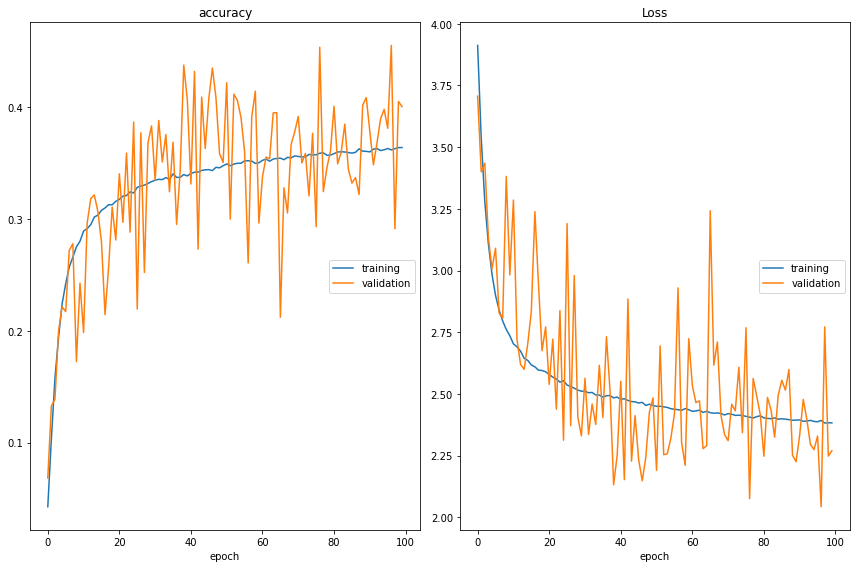

accuracy
	training         	 (min:    0.043, max:    0.364, cur:    0.364)
	validation       	 (min:    0.068, max:    0.455, cur:    0.401)
Loss
	training         	 (min:    2.382, max:    3.912, cur:    2.383)
	validation       	 (min:    2.043, max:    3.707, cur:    2.270)


In [ ]:


batch_size = 128
epochs = 100

classifier = define_classifier(latent_dim)
classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
classifier.summary()

history = classifier.fit(X_train_enc, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val_enc, y_val))

# Classifier from mel features

In [ ]:
from sklearn.model_selection import train_test_split
gc.collect()
X_train, X_val, y_train, y_val = train_test_split(slice_mel, label_slice, test_size=0.2, random_state=111 )

print(np.shape(X_train), '  ', np.shape(X_val))

(186212, 60, 40, 1)    (46554, 60, 40, 1)


In [ ]:
del slice_mel
gc.collect()

0

In [ ]:
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(32,   kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(input)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)  #dont reduce dimension
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier


def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(3,1), strides=(2,2), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,3), strides=(2,2), padding='same')(x)
    x = layers.ReLU()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,3), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,3), strides=(1,1), padding='same')(x) 
    x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

#with separable kernel
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(3,1), strides=(1,1), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,3), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,3), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,3), strides=(1,1), padding='same')(x) 
    x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

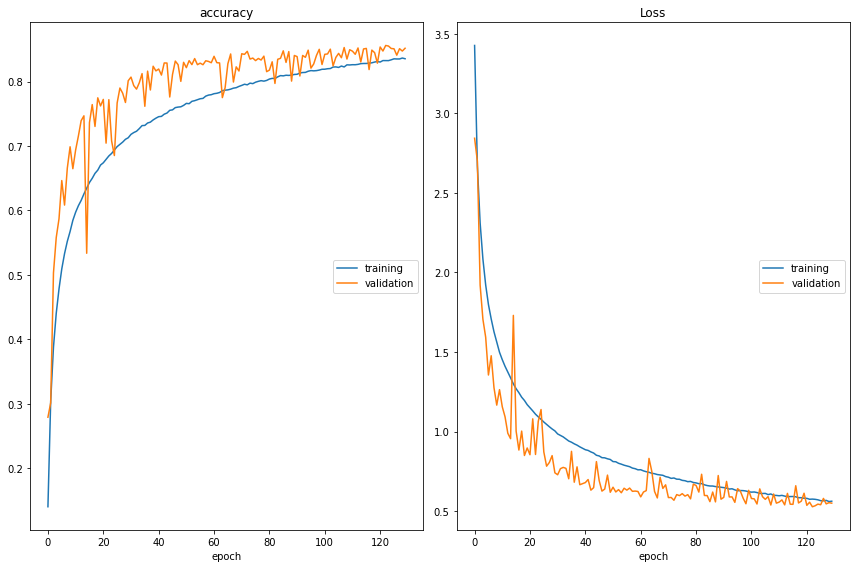

accuracy
	training         	 (min:    0.140, max:    0.837, cur:    0.836)
	validation       	 (min:    0.279, max:    0.856, cur:    0.852)
Loss
	training         	 (min:    0.560, max:    3.427, cur:    0.562)
	validation       	 (min:    0.527, max:    2.844, cur:    0.550)


In [ ]:
gc.collect()

batch_size = 128
epochs = 130

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val
, y_val))

In [ ]:
mel_classifier.summary()

with kernel 5,1 it go near 90% OMG

In [ ]:
#with separable kernel (5,1)
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(5,1), strides=(1,1), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,5), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(5,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,5), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(5,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,5), strides=(1,1), padding='same')(x) 
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

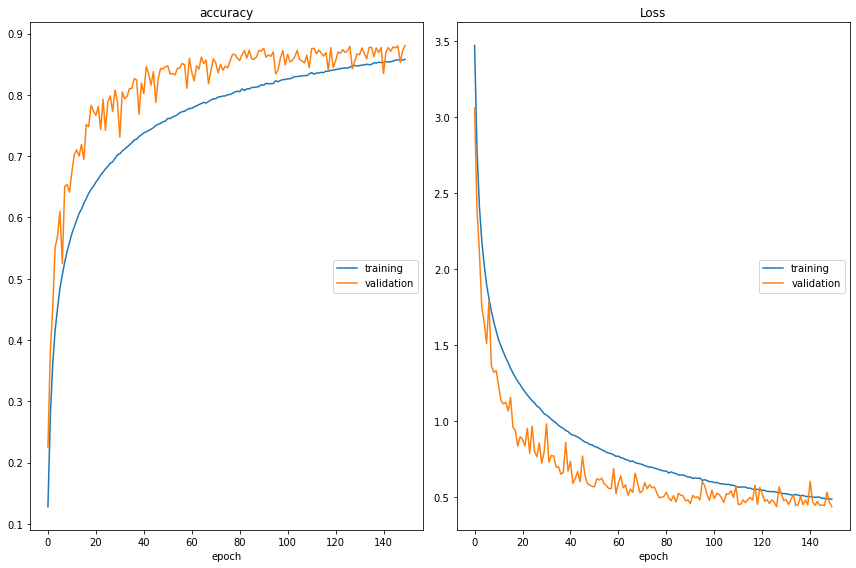

accuracy
	training         	 (min:    0.128, max:    0.858, cur:    0.858)
	validation       	 (min:    0.225, max:    0.881, cur:    0.881)
Loss
	training         	 (min:    0.485, max:    3.473, cur:    0.485)
	validation       	 (min:    0.435, max:    3.062, cur:    0.435)
4824.758947849274


In [ ]:
gc.collect()

start_time = time.time()

batch_size = 128
epochs = 150

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val
, y_val))

elapsed_time = time.time() - start_time
print(elapsed_time/60)

let's try 7,1

In [ ]:
#with separable kernel (7,1)
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(7,1), strides=(1,1), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,7), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(7,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,7), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(7,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,7), strides=(1,1), padding='same')(x) 
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.05)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.05)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

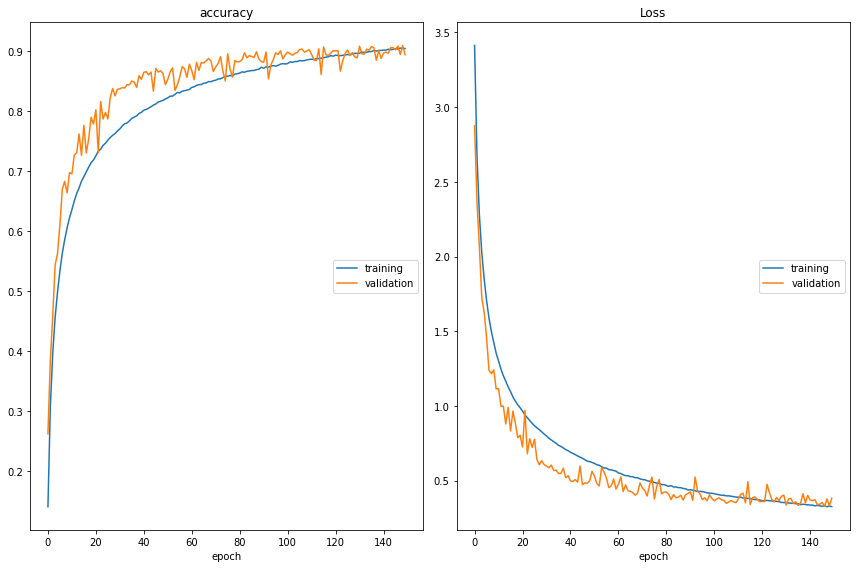

accuracy
	training         	 (min:    0.140, max:    0.905, cur:    0.904)
	validation       	 (min:    0.262, max:    0.909, cur:    0.894)
Loss
	training         	 (min:    0.325, max:    3.413, cur:    0.326)
	validation       	 (min:    0.328, max:    2.876, cur:    0.382)
150.8909046292305


In [ ]:
gc.collect()

start_time = time.time()

batch_size = 128
epochs = 150

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val
, y_val))

elapsed_time = time.time() - start_time
print(elapsed_time/60)

----------------------------------------------------------------